In [21]:
%load_ext autoreload
%autoreload 2
from load import *
import yaml
import logging
from imp import reload
import matplotlib.pyplot as plt
import load
import torch
from liftpose.vision_3d import XY_coord_dict, Z_coord_dict

reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)

# decleare data parameters
par_train = {'data_dir' : '/data/LiftPose3D/mouse_prism', # change the path 
       'out_dir'        : './out',
       'train_subjects' : ['G6AE6','G6AE2','G6AE3','G6AE5'],
       'test_subjects'  : ['G6AE1'],
       'actions'        : ['control']}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

# Load data
train, train_keypts, _ = load.load_3D(par['data_dir'], subjects=par['train_subjects'], actions=par['actions'])
test,  test_keypts, _ = load.load_3D(par['data_dir'], subjects=par['test_subjects'],  actions=par['actions'])
# project data
train_2d, train_3d = XY_coord_dict(train), Z_coord_dict(train)
test_2d, test_3d  = XY_coord_dict(test), Z_coord_dict(test)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
from liftpose.main import train as lp3d_train
lp3d_train(train_2d=train_2d, test_2d=test_2d, train_3d=train_3d, test_3d=test_3d, 
           train_keypts=train_keypts, test_keypts=test_keypts,
           roots=par['roots'],
           target_sets=par['target_sets'],
           out_dir=par['out_dir'], training_kwargs={"epochs":30})

[main.py:252]:INFO:Saving pre-processed 2D data at /home/user/Desktop/LiftPose3D/examples/mouse_prism/out/stat_2d.pth.tar.
[main.py:271]:INFO:Saving pre-processed 3D data at /home/user/Desktop/LiftPose3D/examples/mouse_prism/out/stat_3d.pth.tar.
[main.py:298]:INFO:Starting training model.
[main.py:308]:DEBUG:
==================Options=================
[main.py:309]:DEBUG:{   'batch_size': 64,
    'data_dir': '/home/user/Desktop/LiftPose3D/examples/mouse_prism/out',
    'dropout': 0.5,
    'epochs': 30,
    'exp': '',
    'is_train': True,
    'job': 8,
    'linear_size': 1024,
    'load': None,
    'lr': 0.001,
    'lr_decay': 5000,
    'lr_gamma': 0.9,
    'max_norm': True,
    'noise': None,
    'num_stage': 2,
    'out': '/home/user/Desktop/LiftPose3D/examples/mouse_prism/out',
    'out_dir': '/home/user/Desktop/LiftPose3D/examples/mouse_prism/out',
    'predict': False,
    'procrustes': False,
    'resume': False,
    'test': False}
[main.py:310]:DEBUG:============================

/home/user/Desktop/LiftPose3D/liftpose/preprocess.py:144: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(cp_d, axis=0)
/home/user/anaconda3/envs/lf3d/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
Epoch 000 | LR  0.00100 | Loss Test  0.00000 | Loss Train  2.76124|: 100%|██████████| 451/451 [00:06<00:00, 73.44it/s]
Epoch 001 | LR  0.00100 | Loss Test  1.08174 | Loss Train  1.20081|: 100%|██████████| 451/451 [00:06<00:00, 70.97it/s]
Epoch 002 | LR  0.00100 | Loss Test  0.99276 | Loss Train  0.94409|: 100%|██████████| 451/451 [00:06<00:00, 72.47it/s]
Epoch 003 | LR  0.00100 | Loss Test  1.05655 | Loss Train  0.87702|: 100%|██████████| 451/451 [00:06<00:00, 72.91it/s]
Epoch 004 | LR  0.00100 | Loss Test  0.95508 | Loss Train  0.85894|: 100%|██████████| 451/451 [00:06<00:00, 70.63it/s]
Epoch 005 | LR  0.00100 | Loss Test  0.97743 | Loss Train  0.83143|: 100%|██████████| 451/451 [00:06<00:00, 74.95i

KeyboardInterrupt: 

/home/user/anaconda3/envs/lf3d/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/user/anaconda3/envs/lf3d/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


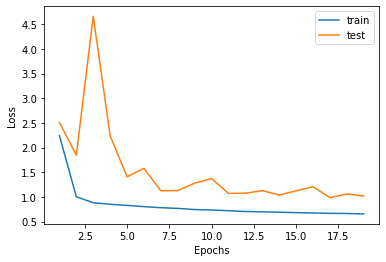

In [3]:
%matplotlib inline
from liftpose.plot import read_log_train, plot_log_train
epoch, lr, loss_train, loss_test, err_test = read_log_train(par['out_dir'])
plot_log_train(plt.gca(), loss_train, loss_test, epoch)

In [24]:
from liftpose.main import test as lp3d_test
lp3d_test(par['out_dir'])

[main.py:409]:INFO:starting testing in path: ./out
[lift.py:31]:INFO:Training on the device: cuda:0
[lift.py:55]:INFO:total params: 4.23M
[lift.py:61]:INFO:loading ckpt from './out/ckpt_best.pth.tar'
[lift.py:69]:INFO:ckpt loaded (epoch: 6 | err: 2.1407705770832908)
[lift.py:105]:INFO:Saving results: /home/user/Desktop/LiftPose3D/examples/mouse_prism/out/test_results.pth.tar


In [25]:
from liftpose.postprocess import load_test_results
data = torch.load(par['out_dir'] + "/test_results.pth.tar")
stat_2d, stat_3d = (
    torch.load(par['out_dir'] + "/stat_2d.pth.tar"),
    torch.load(par['out_dir'] + "/stat_3d.pth.tar"),
)
test_3d_gt, test_3d_pred, good_keypts  = load_test_results(data, stat_2d, stat_3d)

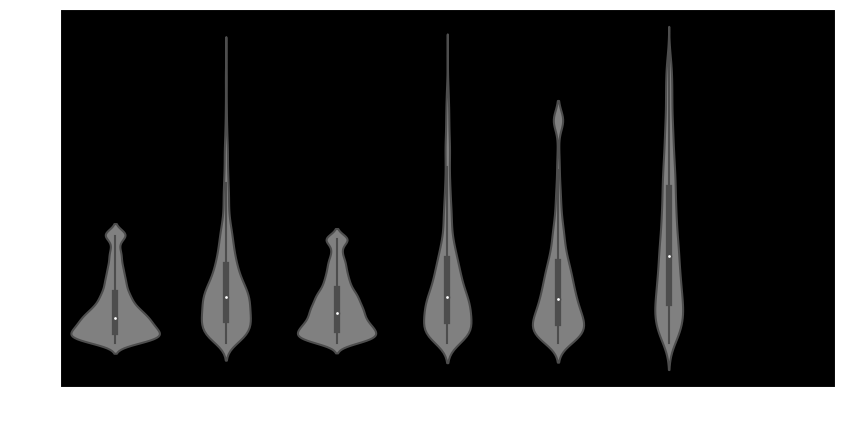

In [10]:
from liftpose.plot import violin_plot
plt.style.use('dark_background')
# check violin plot 
# does it coincide with the mean values?
%matplotlib inline
from liftpose.plot import violin_plot
import random, string
#order = ['HeadF', 'HeadB', 'HeadL', 'SpineM', 'SpineL', 'HipL', 'HipR', 'ElbowL', 'ArmL', 'ShoulderL', 'ShoulderR', 'ElbowR', 'ArmR', 'KneeR', 'KneeL', 'ShinL', 'ShinR']
plt.figure(figsize=(10,5), dpi=100)
names = [str(i) for i in range(7)]
#order = names.copy()
#order.remove('Neck')
#order.remove('Tail')
ax = plt.gca()
violin_plot(ax, test_3d_gt=test_3d_gt, test_3d_pred=test_3d_pred, test_keypoints=good_keypts,
                joints_name=names, order=names)